In [3]:
import os
import numpy as np
import pandas as pd
import librosa
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt, hilbert
import noisereduce as nr
from scipy.stats import skew
from tqdm import tqdm

def butter_bandpass_filter(data, sr, lowcut, highcut, order):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def envelope(y, sr, frame_size=1024, hop_length=512, threshold=0.05):
    """
    Calcula un envelope simple usando RMS en ventanas superpuestas,
    y devuelve una máscara booleana que indica dónde la energía supera el umbral.
    """
    import librosa

    rms = librosa.feature.rms(y=y, frame_length=frame_size, hop_length=hop_length)[0]
    # Normalizamos rms
    rms_norm = (rms - rms.min()) / (rms.max() - rms.min() + 1e-10)
    mask_frames = rms_norm > threshold

    # Expandir la máscara para que tenga la longitud de la señal
    mask = np.zeros(len(y), dtype=bool)
    for i, val in enumerate(mask_frames):
        start = i * hop_length
        end = min(start + frame_size, len(y))
        mask[start:end] = val

    return mask

def extract_func(row, segment_duration, overlap):
    bird = row['ebird_code']
    path = row['file']
    try:
        y, sr = librosa.load(path, sr=22050) #Ya la frecuencia de muestreo es o bien de 48kHz o de 44,1kHz
        #y = butter_bandpass_filter(y, sr, lowcut=1000, highcut=10500, order=4) #aplicamos un butterworth y que los sonidos de las aves se suelen enocntrar entre 1 y 10,5
        y = butter_bandpass_filter(y, sr, lowcut=1000, highcut=10500, order=4) #aplicamos un butterworth y que los sonidos de las aves se suelen enocntrar entre 1 y 10,5
        #y = nr.reduce_noise(y=y, sr=sr)
        #y, sr = librosa.load(path, sr=None)
        #mask = envelope(y, sr, frame_size=1024, hop_length=512, threshold=0.05)
        #y = y * mask

        segment_length = int(segment_duration * sr)
        features = []

        #for i in range(0, len(y), segment_length):
            #segment = y[i:i + segment_length]
        step = segment_length * (1-overlap)  #Porque un overlap = 0.25 implica que cada nuevo segmento comienza después del 75% del anterior.
        step = round(step)
        index_seg = 0 #Comentar si no se usa overlapping
        for start in range(0, len(y) - segment_length + 1, step):
            segment = y[start:start + segment_length]

            if np.any(np.isnan(segment)) or np.any(np.isinf(segment)):
                continue

            if len(segment) < segment_length or np.mean(np.abs(segment)) < 0.02:
            #if len(segment) < segment_length or np.mean(np.abs(segment)) == 0:
            #if np.mean(np.abs(segment)) < 0.02:
                continue

            #n_fft = 1024
            #hop_length = 256
            n_fft = 512
            hop_length = 220

            rms = librosa.feature.rms(y=segment) #Normalizacion para 
            rms_val = rms[0][0]
            if rms_val > 0:
                segment = segment / rms_val

            #mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=40, n_fft=n_fft)
            #mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20, n_fft=n_fft)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20, n_fft=n_fft, hop_length=hop_length) #Fuera momentaneamente para probar MEl
            skewness_mfcc = skew(mfcc, axis=1)
            #skewness_mfcc = skewness_mfcc[:9]
            delta = librosa.feature.delta(mfcc) #Lo quito momentaneamente para probar solo mel. Sin mfcc no tiene sentido delta
            #delta2 = librosa.feature.delta(mfcc, order=2) #SeelctKBest demuestra que da muchos mal.
            #chroma = librosa.feature.chroma_stft(y=segment, sr=sr, n_fft=n_fft) #selectKBest demuestra que da todo el bloque mal. Completamente inutil
            contrast = librosa.feature.spectral_contrast(y=segment, sr=sr, n_fft=n_fft)
            #zcr = librosa.feature.zero_crossing_rate(segment) #selectKBest demuestra que da todo el bloque mal. Completamente inutil
            #centroid = librosa.feature.spectral_centroid(y=segment, sr=sr) #selectKBest demuestra que da todo el bloque mal. Completamente inutil
            #rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr) #selectKBest demuestra que da todo el bloque mal. Completamente inutil
            mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft, hop_length = hop_length, n_mels = 40) #40 mels recomendado para bioacustica.
            #if np.all(mel == 0):
                #print(f"Descartado: mel==0 con RMS={rms_val} en {path}, segmento {i}") #Lo desartamos porque algo que contiene mel=0 no tendra informacion muy relevante. O quiza sí. Comprobamos
                #continue  #Saltar este segmento para evitar NaNs
            #mel_db = librosa.power_to_db(mel, ref=np.max) #Esto da a veces -infinito cuando mel da cero.
            #if np.all(mel < 1e-6):
            #    continue
            mel_db = librosa.power_to_db(mel, ref=np.max, amin=1e-10)
            #tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(segment), sr=sr) #selectKBest demuestra que da todo el bloque mal. Completamente inutil

            vec = np.concatenate([
                np.mean(mfcc, axis=1), np.std(mfcc, axis=1), skewness_mfcc,
                #np.mean(delta, axis=1), np.std(delta, axis=1),
                np.std(delta, axis=1), #delta media daba malos pero std buenos
                #np.mean(delta2, axis=1), np.std(delta2, axis=1),
                #np.mean(chroma, axis=1), np.std(chroma, axis=1),
                np.mean(contrast, axis=1), np.std(contrast, axis=1),
                #np.mean(zcr, axis=1), np.std(zcr, axis=1),
                #np.mean(centroid, axis=1), np.std(centroid, axis=1),
                #np.mean(rolloff, axis=1), np.std(rolloff, axis=1),
                np.mean(mel_db, axis=1), #np.std(mel_db, axis=1), #de mel usaremos solo la media porque hay muchas caracteristicas mel debiles.
                #np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1),
                #np.mean(rms, axis=1), np.std(rms, axis=1)
            ])
            index_seg = index_seg+1
            if np.any(np.isnan(vec)) or np.any(np.isinf(vec)):
                print(f"Segmento descartado por NaN/Inf en características en {path}, segmento {index_seg}")
                continue
            features.append((vec, bird))
        return features

    except Exception as e:
        print(f"Error procesando {path}: {e}")
        return []


#Aquí procesamos los archivos, llamando a la función de extracción de características, para la ulterior exportación a csv.
def extract_and_save_features(df, output_csv_path, segment_duration=None, overlap=1):
    all_features, all_labels = [], []

    print(f"\nIniciando extracción paralela. Tamaño real del DataFrame: {len(df)}\n")

    # Procesar en paralelo
    results = Parallel(n_jobs=-1, prefer="threads")(
        delayed(extract_func)(row, segment_duration, overlap)
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Procesando muestras")
    )

    # Recoger resultados
    for file_result in results:
        for vec, label in file_result:
            all_features.append(vec)
            all_labels.append(label)


    X = np.array(all_features)
    y = np.array(all_labels)

    df_features = pd.DataFrame(X)
    df_features['label'] = y

    if os.path.exists(output_csv_path):
        os.remove(output_csv_path)

    df_features.to_csv(output_csv_path, index=False)

In [5]:
import pandas as pd
import os

current_path = os.getcwd()
csv_total_path =  os.path.join(current_path, "train_total.csv")
df_total = pd.read_csv(csv_total_path, low_memory=False)

durations_by_class = df_total.groupby('ebird_code')['duration'].sum() #Aquí sumamos las duraciones
durations_sorted = durations_by_class.sort_values(ascending=False) #Ordenamos

counts_by_class = df_total['ebird_code'].value_counts()

top_n = 5
top_classes = durations_sorted.head(top_n).index.tolist()
#top_classes = counts_by_class.head(top_n).index.tolist() 

print(f"Clases seleccionadas: {top_classes}")
segmentDuration=8.5
overlap = 0.5  #Porcentaje de solapamiento

df_filtered  = df_total[df_total['ebird_code'].isin(top_classes)].copy()

audios_path =  os.path.join(current_path, "train_audio")

df_filtered['file'] = df_filtered.apply(
    lambda row: os.path.join(audios_path, row['ebird_code'], row['filename']), #De esta manera ponemos en el DataFrame la dirección de cada archivo.
    axis=1
)

output_csv_name = "features_"+ str(top_n) +"birds.csv"
output_csv_path =  os.path.join(current_path, output_csv_name)
extract_and_save_features(df_filtered, output_csv_path, segment_duration=segmentDuration, overlap=overlap)

Clases seleccionadas: ['houspa', 'redcro', 'eursta', 'comrav', 'houwre']

Iniciando extracción paralela. Tamaño real del DataFrame: 5995



C:\Users\marti\AppData\Local\Temp\ipykernel_18884\2460952872.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=22050) #Ya la frecuencia de muestreo es o bien de 48kHz o de 44,1kHz
c:\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error procesando d:\Temas Academicos\INGENIERIA_DE_TELECOMUNICACIONES\TFG\pajaros_identificacion\train_audio\redcro\XC384196.mp3: 


Procesando muestras: 100%|██████████| 5995/5995 [05:49<00:00, 17.13it/s]


In [6]:
import pandas as pd

current_path = os.getcwd()
csv_path =  os.path.join(current_path, "features_5birds.csv")
df = pd.read_csv(csv_path)

X = df.drop(columns=["label"]).values
y = df["label"].values

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [74]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    StandardScaler(), #Aquí esto sí es muy importante
    SVC()
)

param_grid = {
    'svc__C': [1, 10], #Regularizamos
    'svc__kernel': ['linear', 'rbf'], #Tipos de kernel
    'svc__gamma': ['scale', 'auto'] #Para kernel RBF
}

grid_search_svc = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_svc.fit(X_train, y_train)

print("Mejores hiperparámetros (SVC):", grid_search_svc.best_params_)

Mejores hiperparámetros (SVC): {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


Numero total de features: 134
k = 8 --> Accuracy media: 0.6777777777777778
k = 16 --> Accuracy media: 0.7393743257820927
k = 24 --> Accuracy media: 0.7666666666666666
k = 32 --> Accuracy media: 0.7824163969795037
k = 40 --> Accuracy media: 0.8073354908306365
k = 48 --> Accuracy media: 0.8186623516720605
k = 56 --> Accuracy media: 0.8225458468176914
k = 64 --> Accuracy media: 0.8248112189859762
k = 72 --> Accuracy media: 0.8243797195253506
k = 80 --> Accuracy media: 0.8288025889967638
k = 88 --> Accuracy media: 0.8340884573894284
k = 96 --> Accuracy media: 0.8404530744336569
k = 104 --> Accuracy media: 0.845091693635383
k = 112 --> Accuracy media: 0.8529665587918016
k = 120 --> Accuracy media: 0.8512405609492987
k = 128 --> Accuracy media: 0.8501618122977346
k = 134 --> Accuracy media: 0.8494066882416398
Total de features: 134
Features más débiles (las que sobran): [81 14 45 88 55  0 49 98 58 97 83 99 54 96 53 87 52  8 57 16 40 56]


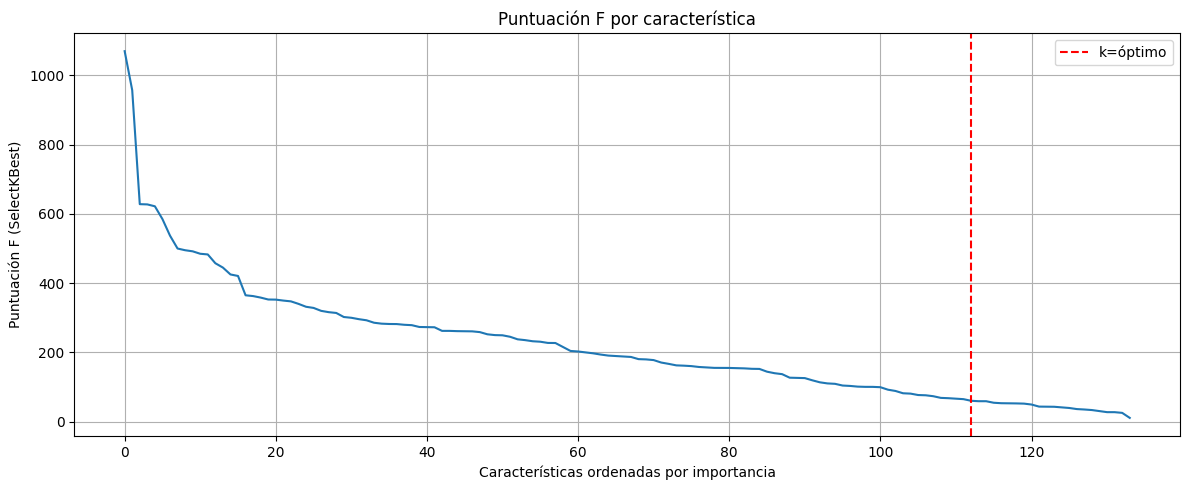

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.svm import SVC

total_features = X.shape[1]
print(f"Numero total de features: {total_features}")

num_k_values = 14  # Número de valores deseado
step = max(1, total_features // (num_k_values + 1))
k_values = list(range(step, total_features + 1, step))

mean_scores = []
for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        SelectKBest(score_func=f_classif, k=k),
        SVC(C=10, kernel='rbf', gamma='scale')
    )

    scores = cross_val_score(pipeline, X, y_encoded, cv=10, scoring='accuracy', n_jobs = -1)
    acc = np.mean(scores)
    mean_scores.append(acc)
    print(f"k = {k} --> Accuracy media: {acc}")

model = SVC(C=10, kernel='rbf', gamma='scale')  #Aquí rbf es el kernel no lineal por defecto. Luego puedo probar otros.
pipeline = make_pipeline(StandardScaler(), model)
scores = cross_val_score(pipeline, X, y_encoded, cv=10, scoring="accuracy", n_jobs = -1)
print(f"k = {total_features} --> Accuracy media: {np.mean(scores):}")

selector = SelectKBest(score_func=f_classif, k='all')  # k='all' para obtener todas las puntuaciones
selector.fit(X, y_encoded)

scores = selector.scores_

# Ordenamos por puntuación
sorted_indices = np.argsort(scores)[::-1]  # De mayor a menor

best_k_index = np.argmax(mean_scores)
top_k = k_values[best_k_index]

top_features = sorted_indices[:top_k]
low_features = sorted_indices[top_k:]

print(f"Total de features: {len(scores)}")
print(f"Features más débiles (las que sobran): {low_features}")

plt.figure(figsize=(12, 5))
plt.plot(sorted(scores, reverse=True))
plt.title("Puntuación F por característica")
plt.xlabel("Características ordenadas por importancia")
plt.ylabel("Puntuación F (SelectKBest)")
plt.axvline(x=top_k, color='red', linestyle='--', label='k=óptimo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

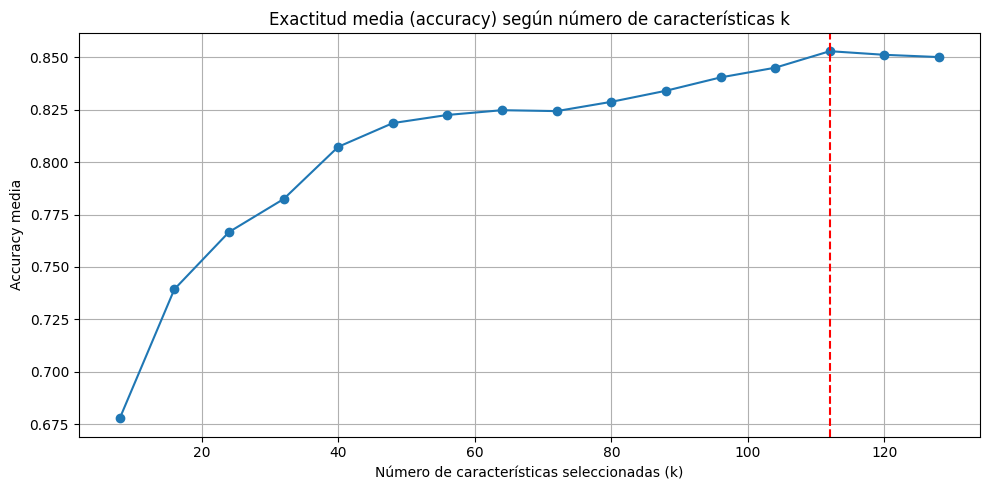

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, mean_scores, marker='o', linestyle='-')
plt.title("Exactitud media (accuracy) según número de características k")
plt.xlabel("Número de características seleccionadas (k)")
plt.ylabel("Accuracy media")
plt.axvline(x=top_k, color='red', linestyle='--', label='k=óptimo')
plt.grid(True)
plt.tight_layout()
plt.show()

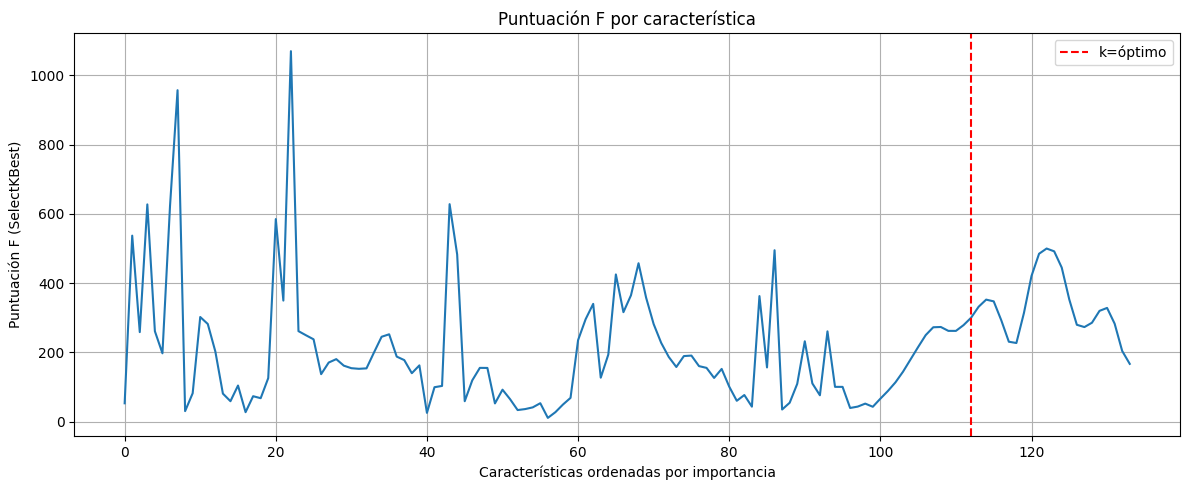

In [62]:
plt.figure(figsize=(12, 5))
plt.plot(scores)
plt.title("Puntuación F por característica")
plt.xlabel("Características ordenadas por importancia")
plt.ylabel("Puntuación F (SelectKBest)")
plt.axvline(x=top_k, color='red', linestyle='--', label='k=óptimo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def interpretar_indices(indices):
    """
    Dada una lista de índices (de features), agrupa por bloque y muestra
    qué características corresponden y cuáles índices fallan.

    También imprime los rangos completos de cada bloque.
    """

    # Definimos bloques y rangos
    bloques = {
        "MFCC media": (0, 19),
        "MFCC std": (20, 39),
        "MFCC skewness": (40, 59),
        #"Delta MFCC media": (60, 79),
        "Delta MFCC std": (60, 79),
        "Spectral contrast media": (80, 86),
        "Spectral contrast std": (87, 93),
        "Mel spectrogram media": (94, 133),
    }

    print("Rangos de características completas:")
    for nombre, (start, end) in bloques.items():
        print(f"  {nombre}: indices {start} a {end}")

    # Agrupar índices dados según el bloque al que pertenecen
    agrupados = {nombre: [] for nombre in bloques}

    for idx in indices:
        encontrado = False
        for nombre, (start, end) in bloques.items():
            if start <= idx <= end:
                agrupados[nombre].append(idx)
                encontrado = True
                break
        if not encontrado:
            print(f"Índice {idx} no pertenece a ningún bloque conocido.")

    print("\nÍndices que fallan agrupados por característica:")
    for nombre, inds in agrupados.items():
        if inds:
            print(f"  {nombre} ({len(inds)} indices): {sorted(inds)}")

interpretar_indices(low_features)

Rangos de características completas:
  MFCC media: indices 0 a 19
  MFCC std: indices 20 a 39
  MFCC skewness: indices 40 a 59
  Delta MFCC std: indices 60 a 79
  Spectral contrast media: indices 80 a 86
  Spectral contrast std: indices 87 a 93
  Mel spectrogram media: indices 94 a 134

Índices que fallan agrupados por característica:
  MFCC media (4 indices): [0, 8, 14, 16]
  MFCC skewness (10 indices): [40, 45, 49, 52, 53, 54, 55, 56, 57, 58]
  Spectral contrast media (2 indices): [81, 83]
  Spectral contrast std (2 indices): [87, 88]
  Mel spectrogram media (4 indices): [96, 97, 98, 99]


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Parámetros del modelo
n_estimators = 300   # Número de árboles
max_depth = 20     # Puedes ajustar, por ejemplo 30 o 50

# Pipeline sin selección de características
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        min_samples_split = 2,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
)

# Evaluación
scores = cross_val_score(pipeline, X, y_encoded, cv=10, scoring='accuracy', n_jobs=-1)

print(f"Accuracy promedio con Random Forest (sin SelectKBest): {np.mean(scores)}")

Accuracy promedio con Random Forest (sin SelectKBest): 0.8003236245954695


In [64]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

pipeline = make_pipeline(StandardScaler(), model)

scores = cross_val_score(pipeline, X, y_encoded, cv=10, scoring="accuracy")

print(f"KNN Accuracy promedio (10-fold CV): {np.mean(scores)}")

KNN Accuracy promedio (10-fold CV): 0.7432578209277239


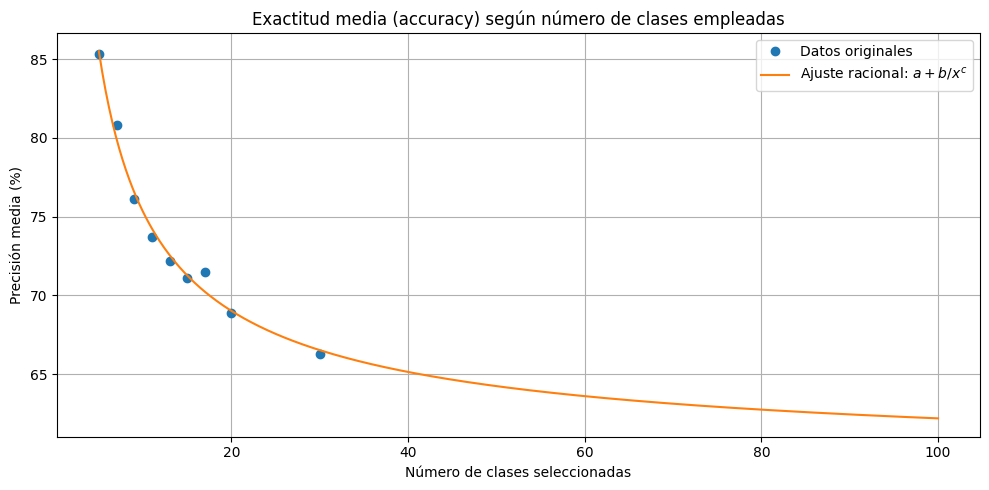

Modelo ajustado: y = 58.91 + 81.70 / x^0.70


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Datos
x = np.array([5, 7, 9, 11, 13, 15, 17, 20, 30])
y = np.array([85.3, 80.8, 76.1, 73.7, 72.2, 71.1, 71.5, 68.9, 66.3])

# Modelo racional
def rational_model(x, a, b, c):
    return a + b / (x ** c)

# Ajuste
popt, _ = curve_fit(rational_model, x, y, bounds=([0, -100, 0], [100, 100, 10]))

# Rango extendido
x_ext = np.linspace(5, 100, 500)
y_ext = rational_model(x_ext, *popt)

# Recortar valores extremos por seguridad
y_ext = np.clip(y_ext, 0, 100)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'o', label='Datos originales')
plt.plot(x_ext, y_ext, '-', label='Ajuste racional: $a + b/x^c$')
plt.title("Exactitud media (accuracy) según número de clases empleadas")
plt.xlabel("Número de clases seleccionadas")
plt.ylabel("Precisión media (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar parámetros ajustados si quieres
print(f"Modelo ajustado: y = {popt[0]:.2f} + {popt[1]:.2f} / x^{popt[2]:.2f}")


Probaremos a continuación a mostrar para 7 clases la accuracy, precision, recall y F-measure.

In [9]:
import pandas as pd
import os

current_path = os.getcwd()
csv_total_path =  os.path.join(current_path, "train_total.csv")
df_total = pd.read_csv(csv_total_path, low_memory=False)

durations_by_class = df_total.groupby('ebird_code')['duration'].sum() #Aquí sumamos las duraciones
durations_sorted = durations_by_class.sort_values(ascending=False) #Ordenamos

counts_by_class = df_total['ebird_code'].value_counts()

top_n = 7
top_classes = durations_sorted.head(top_n).index.tolist()
#top_classes = counts_by_class.head(top_n).index.tolist() 

print(f"Clases seleccionadas: {top_classes}")
segmentDuration=8.5
overlap = 0.5  #Porcentaje de solapamiento

df_filtered  = df_total[df_total['ebird_code'].isin(top_classes)].copy()

audios_path =  os.path.join(current_path, "train_audio")

df_filtered['file'] = df_filtered.apply(
    lambda row: os.path.join(audios_path, row['ebird_code'], row['filename']), #De esta manera ponemos en el DataFrame la dirección de cada archivo.
    axis=1
)

output_csv_name = "features_"+ str(top_n) +"birds.csv"
output_csv_path =  os.path.join(current_path, output_csv_name)
extract_and_save_features(df_filtered, output_csv_path, segment_duration=segmentDuration, overlap=overlap)


current_path = os.getcwd()
csv_path =  os.path.join(current_path, "features_7birds.csv")
df = pd.read_csv(csv_path)

X = df.drop(columns=["label"]).values
y = df["label"].values

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    StandardScaler(), #Aquí esto sí es muy importante
    SVC()
)

param_grid = {
    'svc__C': [1, 10], #Regularizamos
    'svc__kernel': ['linear', 'rbf'], #Tipos de kernel
    'svc__gamma': ['scale', 'auto'] #Para kernel RBF
}

grid_search_svc = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_svc.fit(X_train, y_train)

print("Mejores hiperparámetros (SVC):", grid_search_svc.best_params_)

best_params = grid_search_svc.best_params_
best_C = best_params['svc__C']
best_kernel = best_params['svc__kernel']
best_gamma = best_params['svc__gamma']

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

total_features = X.shape[1]
print(f"Numero total de features: {total_features}")

num_k_values = 14  # Número de valores deseado
step = max(1, total_features // (num_k_values + 1))
k_values = list(range(step, total_features + 1, step))

mean_scores = []
for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        SelectKBest(score_func=f_classif, k=k),
        SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)
    )

    y_pred = cross_val_predict(pipeline, X, y_encoded, cv=10, n_jobs=-1)

    acc = accuracy_score(y_encoded, y_pred)
    prec = precision_score(y_encoded, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_encoded, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_encoded, y_pred, average='macro', zero_division=0)

    mean_scores.append(acc)  # Solo accuracy para mantener consistencia en top_k
    print(f"k = {k} --> Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1-score: {f1}")

model = SVC(C=10, kernel='rbf', gamma='scale')  #Aquí rbf es el kernel no lineal por defecto. Luego puedo probar otros.
pipeline = make_pipeline(StandardScaler(), model)
y_pred = cross_val_predict(pipeline, X, y_encoded, cv=10, n_jobs=-1)
acc = accuracy_score(y_encoded, y_pred)
prec = precision_score(y_encoded, y_pred, average='macro', zero_division=0)
rec = recall_score(y_encoded, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_encoded, y_pred, average='macro', zero_division=0)

print(f"k = {total_features} --> Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1-score: {f1}")

selector = SelectKBest(score_func=f_classif, k='all')  # k='all' para obtener todas las puntuaciones
selector.fit(X, y_encoded)

scores = selector.scores_

# Ordenamos por puntuación
sorted_indices = np.argsort(scores)[::-1]  # De mayor a menor

best_k_index = np.argmax(mean_scores)
top_k = k_values[best_k_index]

top_features = sorted_indices[:top_k]
low_features = sorted_indices[top_k:]

print(f"Total de features: {len(scores)}")
print(f"Features más débiles (las que sobran): {low_features}")

Clases seleccionadas: ['houspa', 'redcro', 'eursta', 'comrav', 'houwre', 'sonspa', 'normoc']

Iniciando extracción paralela. Tamaño real del DataFrame: 7045



Procesando muestras:  83%|████████▎ | 5856/7045 [05:36<00:35, 33.57it/s]C:\Users\marti\AppData\Local\Temp\ipykernel_19860\2460952872.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=22050) #Ya la frecuencia de muestreo es o bien de 48kHz o de 44,1kHz
c:\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Procesando muestras:  83%|████████▎ | 5862/7045 [05:36<00:31, 37.37it/s]

Error procesando d:\Temas Academicos\INGENIERIA_DE_TELECOMUNICACIONES\TFG\pajaros_identificacion\train_audio\redcro\XC384196.mp3: 


Procesando muestras: 100%|██████████| 7045/7045 [06:26<00:00, 18.25it/s]


Mejores hiperparámetros (SVC): {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Numero total de features: 134
k = 8 --> Accuracy: 0.5371062033127639, Precision: 0.5251924207443323, Recall: 0.5028115734436386, F1-score: 0.5114395332168484
k = 16 --> Accuracy: 0.6705911010068204, Precision: 0.6658964557042042, Recall: 0.6536769924824057, F1-score: 0.6585562270774015
k = 24 --> Accuracy: 0.6980350763234816, Precision: 0.6901032171062446, Recall: 0.6855175176284346, F1-score: 0.6865535048910557
k = 32 --> Accuracy: 0.7076973043195843, Precision: 0.7021209142484081, Recall: 0.6951599874715182, F1-score: 0.696963538663952
k = 40 --> Accuracy: 0.742611237414745, Precision: 0.7362871156322482, Recall: 0.729447107578369, F1-score: 0.7317749593081795
k = 48 --> Accuracy: 0.7577947385514777, Precision: 0.7550536251656801, Recall: 0.7438801478922384, F1-score: 0.7481145805796711
k = 56 --> Accuracy: 0.7694868463786944, Precision: 0.7678347927379817, Recall: 0.7567610047703105, F1-score:

Mejores resultados obtenidos para k=88
Con los siguientes valores obtenidos --> Accuracy: 0.8081357583631049, Precision: 0.807296492307213, Recall: 0.7953183629584897, F1-score: 0.8000290299032545
        precision  recall  f1-score  support     Duración
comrav     0.9172  0.8571    0.8862    672.0   28h 45m 5s
eursta     0.7450  0.8064    0.7745   1761.0   24h 31m 5s
houspa     0.8885  0.8890    0.8888   3497.0  18h 16m 46s
houwre     0.7557  0.7749    0.7652   2012.0  17h 19m 21s
normoc     0.7747  0.8165    0.7950   1689.0   14h 2m 40s
redcro     0.7542  0.7417    0.7479   1328.0  11h 36m 41s
sonspa     0.8157  0.6817    0.7427   1357.0  10h 23m 31s
Duración media: 17h 50m 44s


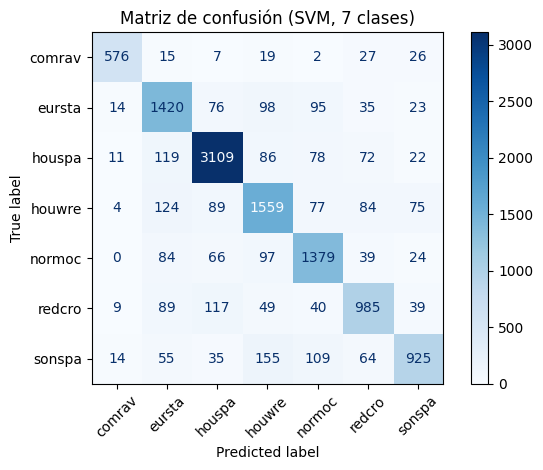

In [12]:
print(f"Mejores resultados obtenidos para k={top_k}")

pipeline = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_classif, k=top_k),
    SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)
    )

y_pred = cross_val_predict(pipeline, X, y_encoded, cv=10, n_jobs=-1)

acc = accuracy_score(y_encoded, y_pred)
prec = precision_score(y_encoded, y_pred, average='macro', zero_division=0)
rec = recall_score(y_encoded, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_encoded, y_pred, average='macro', zero_division=0)

print(f"Con los siguientes valores obtenidos --> Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1-score: {f1}")

from sklearn.metrics import classification_report

segundos = durations_sorted.head(top_n) % 60
mins = (durations_sorted.head(top_n) % 3600) // 60
horas = durations_sorted.head(top_n) // 3600

duracion = [
    f"{int(h)}h {int(m)}m {int(s)}s"
    for h, m, s in zip(horas, mins, segundos)
]

report_dict = classification_report(
    y_encoded,
    y_pred,
    target_names=encoder.classes_,
    output_dict=True,
    zero_division=0
)

# Convertir a DataFrame
report_df = pd.DataFrame(report_dict).T.iloc[:-3]  # Excluimos 'accuracy', 'macro avg', 'weighted avg'

# Añadir duración en minutos
report_df["Duración"] = duracion

# Redondear todo a 4 decimales
report_df = report_df.round(4)

print(report_df)

duraciones = durations_sorted.head(top_n)  # Serie con duraciones en segundos
media_segundos = duraciones.mean()

horas = int(media_segundos // 3600)
minutos = int((media_segundos % 3600) // 60)
segundos = int(media_segundos % 60)

media_formateada = f"{horas}h {minutos}m {segundos}s"
print("Duración media:", media_formateada)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = encoder.classes_ 

cm = confusion_matrix(y_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)

import matplotlib.pyplot as plt

plt.title("Matriz de confusión (SVM, 7 clases)")
plt.tight_layout()
plt.show()

Comparativa SVM, Random Forest y KNN, ahora con 7 clases. Se están usando valores optimos en todos los casos, obtenidos con gridsearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

n_estimators = 300
max_depth = 20

num_k_values = 14
step = max(1, total_features // (num_k_values + 1))
k_values = list(range(step, total_features + 1, step))

mean_scores = []

for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        SelectKBest(score_func=f_classif, k=k),
        RandomForestClassifier(
            min_samples_split=2,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            n_jobs=-1
        )
    )

    y_pred = cross_val_predict(pipeline, X, y_encoded, cv=10, n_jobs=-1)
    acc = accuracy_score(y_encoded, y_pred)
    prec = precision_score(y_encoded, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_encoded, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_encoded, y_pred, average='macro', zero_division=0)

    mean_scores.append(acc)
    print(f"Random Forest - k = {k} --> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")



Random Forest - k = 8 --> Acc: 0.5172, Prec: 0.5115, Rec: 0.4930, F1: 0.5005
Random Forest - k = 16 --> Acc: 0.6466, Prec: 0.6444, Rec: 0.6316, F1: 0.6368
Random Forest - k = 24 --> Acc: 0.6832, Prec: 0.6782, Rec: 0.6657, F1: 0.6702
Random Forest - k = 32 --> Acc: 0.6993, Prec: 0.6974, Rec: 0.6795, F1: 0.6858
Random Forest - k = 40 --> Acc: 0.7133, Prec: 0.7133, Rec: 0.6915, F1: 0.6995
Random Forest - k = 48 --> Acc: 0.7251, Prec: 0.7252, Rec: 0.7040, F1: 0.7117
Random Forest - k = 56 --> Acc: 0.7269, Prec: 0.7280, Rec: 0.7076, F1: 0.7149
Random Forest - k = 64 --> Acc: 0.7360, Prec: 0.7349, Rec: 0.7166, F1: 0.7233
Random Forest - k = 72 --> Acc: 0.7489, Prec: 0.7508, Rec: 0.7299, F1: 0.7375
Random Forest - k = 80 --> Acc: 0.7509, Prec: 0.7537, Rec: 0.7295, F1: 0.7381
Random Forest - k = 88 --> Acc: 0.7530, Prec: 0.7571, Rec: 0.7348, F1: 0.7426
Random Forest - k = 96 --> Acc: 0.7519, Prec: 0.7571, Rec: 0.7330, F1: 0.7410
Random Forest - k = 104 --> Acc: 0.7545, Prec: 0.7588, Rec: 0.734

In [6]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

mean_scores = []

for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        SelectKBest(score_func=f_classif, k=k),
        model
    )

    y_pred = cross_val_predict(pipeline, X, y_encoded, cv=10, n_jobs=-1)

    acc = accuracy_score(y_encoded, y_pred)
    prec = precision_score(y_encoded, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_encoded, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_encoded, y_pred, average='macro', zero_division=0)

    mean_scores.append(acc)
    print(f"KNN - k = {k} --> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

KNN - k = 8 --> Acc: 0.4665, Prec: 0.4472, Rec: 0.4486, F1: 0.4471
KNN - k = 16 --> Acc: 0.6008, Prec: 0.5938, Rec: 0.5867, F1: 0.5897
KNN - k = 24 --> Acc: 0.6285, Prec: 0.6177, Rec: 0.6090, F1: 0.6128
KNN - k = 32 --> Acc: 0.6452, Prec: 0.6406, Rec: 0.6235, F1: 0.6310
KNN - k = 40 --> Acc: 0.6553, Prec: 0.6534, Rec: 0.6300, F1: 0.6399
KNN - k = 48 --> Acc: 0.6671, Prec: 0.6700, Rec: 0.6428, F1: 0.6542
KNN - k = 56 --> Acc: 0.6749, Prec: 0.6773, Rec: 0.6510, F1: 0.6620
KNN - k = 64 --> Acc: 0.6782, Prec: 0.6809, Rec: 0.6536, F1: 0.6650
KNN - k = 72 --> Acc: 0.6851, Prec: 0.6866, Rec: 0.6601, F1: 0.6713
KNN - k = 80 --> Acc: 0.6902, Prec: 0.6895, Rec: 0.6645, F1: 0.6749
KNN - k = 88 --> Acc: 0.6984, Prec: 0.7008, Rec: 0.6748, F1: 0.6858
KNN - k = 96 --> Acc: 0.6971, Prec: 0.6993, Rec: 0.6724, F1: 0.6838
KNN - k = 104 --> Acc: 0.7010, Prec: 0.7048, Rec: 0.6768, F1: 0.6888
KNN - k = 112 --> Acc: 0.6960, Prec: 0.6982, Rec: 0.6750, F1: 0.6851
KNN - k = 120 --> Acc: 0.6914, Prec: 0.6971, Re